In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
import torch.nn.functional as F

c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Mount the drive

## Visualizing Coarse damage

## Loading the Coarse damage dataset

In [2]:
class CustomSemanticSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None, target_size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform  # Separate transform for masks
        self.target_size = target_size
        self.num_classes = 8

        # Include only image files
        self.image_filenames = [f for f in sorted(os.listdir(image_dir))
                                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.png'))

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        # Resize the image and mask
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)

        # Convert mask to numpy array for processing
        mask = np.array(mask)

        # Create one-hot encoding for mask
        mask_one_hot = torch.zeros((self.num_classes, *self.target_size), dtype=torch.float32)
        for class_idx in range(self.num_classes):
            mask_one_hot[class_idx] = torch.from_numpy(mask == class_idx).float()

        return image, mask_one_hot


## Load data

In [3]:
image_dir = r"C:\Users\skoka3\Desktop\CIVE-FP\data\imageDamage"
mask_dir = r"C:\Users\skoka3\Desktop\CIVE-FP\data\CoarseDamagePNG"

In [4]:
# Refactored code here
def load_mask(mask_path, num_classes=7):
    # Load the mask image
    mask_image = Image.open(mask_path)
    
    # Convert mask image to numpy array
    mask_array = np.array(mask_image)
    
    # If mask is RGB, convert it to a unique class map
    if len(mask_array.shape) == 3:  # RGB image
        # Convert RGB to a unique number (assuming 8-bit per channel)
        mask = mask_array[:, :, 0] * 256 * 256 + mask_array[:, :, 1] * 256 + mask_array[:, :, 2]
        
        # Map unique RGB combinations to class indices
        unique_colors = np.unique(mask)
        color_to_class = {color: idx for idx, color in enumerate(unique_colors)}
        mask_class_map = np.vectorize(color_to_class.get)(mask)
        
        # Clip to number of classes
        mask_class_map = np.clip(mask_class_map, 0, num_classes)
        
        return mask_class_map
    else:
        # If mask is already in single channel format, just return it
        return mask_array

# Refactored code here
class CustomImageSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_names, augmentation=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_names = [name for name in img_names if name.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.augmentation = augmentation

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        mask_path = os.path.join(self.mask_dir, self.img_names[idx].replace('.jpg', '.png'))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = load_mask(mask_path)

        if self.augmentation:
                        # Apply a default resizing if no augmentation is provided
            resize_transform = A.Compose([A.Resize(512, 512)])  # Adjust size as needed
            augmented = resize_transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        else:
            # Apply a default resizing if no augmentation is provided
            resize_transform = A.Compose([A.Resize(512, 512)])  # Adjust size as needed
            augmented = resize_transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        image = torch.from_numpy(image).permute(2, 0, 1) / 255.0
        mask = torch.from_numpy(mask).long()

        return {"images": image, "masks": mask}
    
# Training Augmentations
def get_training_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # Add more transformations as needed
    ])


## Train the model

In [5]:
from unetformer import UNetFormer

In [6]:
# Refactored code here
# Disable unwanted logging (e.g., Weights & Biases)
os.environ["WANDB_DISABLED"] = "true"

# Constants and Configuration
NUM_CLASSES = 7
IMAGE_DIR = "data\imageDamage"
MASK_DIR = "data\FineDamageReducedPNG"
CHECKPOINT = "shi-labs/dinat-mini-in1k-224"


In [7]:

from sklearn.model_selection import train_test_split# Refactored code here
img_names = os.listdir(IMAGE_DIR)
train_val_img_names, test_img_names = train_test_split(img_names, test_size=0.15, random_state=42)
train_img_names, valid_img_names = train_test_split(train_val_img_names, test_size=0.15, random_state=42)


train_dataset = CustomImageSegmentationDataset(
    img_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    img_names=train_img_names,  # Slice for demonstration
    augmentation=get_training_augmentation(),
    # num_classes=NUM_CLASSES
)

valid_dataset = CustomImageSegmentationDataset(
    img_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    img_names=valid_img_names,  # Slice for demonstration
    # num_classes=NUM_CLASSES
)

test_dataset = CustomImageSegmentationDataset(
    img_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    img_names=test_img_names,  # Slice for demonstration
    # num_classes=NUM_CLASSES
)


In [8]:
# Define your color map according to the specified classes and colors
color_map = {
    0: [0, 0, 0],       # No - black
    1: [255, 0, 0],     # Scratches - red
    2: [0, 255, 0],     # Grooves/Joints - green
    3: [255, 255, 255], # Cables - white
    4: [211, 211, 211], # Filled Cracks - lightgrey
    5: [255, 0, 0],     # Cracks - red
    6: [255, 165, 0]    # Exposed Rebar - orange
}

# Function to apply color mapping to an image
def apply_color_map(image, color_map):
    height, width = image.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for key, color in color_map.items():
        indices = image == key
        color_mask[indices] = color
    return color_mask


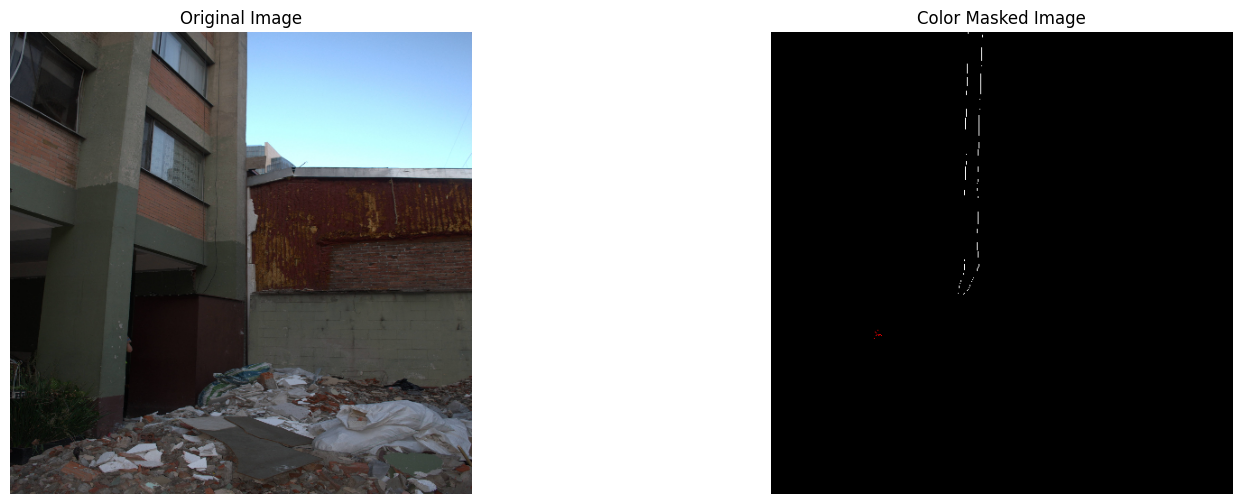

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def apply_color_map(mask, color_map):
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for key, color in color_map.items():
        indices = mask == key
        color_mask[indices] = color
    return color_mask

# Assuming image and mask are PyTorch tensors
index = 13  # Adjust this index as needed
image = test_dataset[index]['images']
mask = test_dataset[index]['masks']

# Convert the image to NumPy and change the dimension order
image_np = image.permute(1, 2, 0).numpy()  # Rearrange dimensions to HWC

# Convert the mask to NumPy
mask_np = mask.numpy()

# Apply color mapping to the mask
color_mask_np = apply_color_map(mask_np, color_map)

# Create subplots
plt.figure(figsize=(18, 6))  # Adjust the figure size as needed

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.axis('off')
plt.title('Original Image')

# Display the color-masked image
plt.subplot(1, 2, 2)
plt.imshow(color_mask_np)
plt.axis('off')
plt.title('Color Masked Image')

plt.show()



In [10]:
def compute_miou(preds, targets, num_classes=7):
    iou_per_class = []
    batch_size = preds.size(0)
    
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).float().sum(dim=[1, 2])  # Intersection over batch
        union = pred_inds.float().sum(dim=[1, 2]) + target_inds.float().sum(dim=[1, 2]) - intersection  # Union over batch
        
        iou = intersection / (union + 1e-6)
        iou_per_class.append(iou.mean().item())  # Mean IoU per class over batch

    return np.nanmean(iou_per_class)  # Mean IoU across all classes


In [11]:
# Define hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 100
num_classes = 7


# Define your custom dataset and data loaders
custom_dataset = CustomSemanticSegmentationDataset(image_dir, mask_dir, transform=transforms.Compose([transforms.ToTensor()]), target_size=(512,512))
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

# Load the UNetFormer model
model = UNetFormer(decode_channels=128, dropout=0.1, backbone_name='swsl_resnet18', pretrained=True, window_size=8, num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name swsl_resnet18 to current resnet18.fb_swsl_ig1b_ft_in1k.
  model = create_fn(
c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
BATCH_SIZE = 8
LEARNING_RATE = 0.0001

In [13]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn

# Assuming you have a PyTorch Dataset for your data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define the optimizer and loss function
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


In [14]:
def resize_output(output, target_size):
    return F.interpolate(output, size=target_size, mode='bilinear', align_corners=False)


def convert_to_one_hot(preds, num_classes):
    # Expanding the last dimension and converting to one-hot encoding
    return F.one_hot(preds, num_classes).permute(0, 3, 1, 2).float()



In [16]:
# Define hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 100
num_classes = 8

# Define your custom dataset and data loaders
custom_dataset = CustomSemanticSegmentationDataset(image_dir, mask_dir, transform=transforms.Compose([transforms.ToTensor()]), target_size=(256,256))
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

# Load the UNetFormer model
model = UNetFormer(decode_channels=64, dropout=0.1, backbone_name='swsl_resnet18', pretrained=True, window_size=8, num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    for inputs, masks in progress_bar:
        inputs, masks = inputs.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        main_output = outputs[0] if isinstance(outputs, tuple) else outputs

        # Convert one-hot encoded masks to class indices
        masks = masks.argmax(dim=1)

        loss = criterion(main_output, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")



# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_UNetFormer_model.pth')


Epoch 1/100: 100%|██████████| 70/70 [00:29<00:00,  2.35it/s]


Epoch 1/100, Loss: 0.8818


Epoch 2/100: 100%|██████████| 70/70 [00:27<00:00,  2.54it/s]


Epoch 2/100, Loss: 0.3175


Epoch 3/100: 100%|██████████| 70/70 [00:28<00:00,  2.47it/s]


Epoch 3/100, Loss: 0.2687


Epoch 4/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 4/100, Loss: 0.2432


Epoch 5/100: 100%|██████████| 70/70 [00:34<00:00,  2.01it/s]


Epoch 5/100, Loss: 0.2364


Epoch 6/100: 100%|██████████| 70/70 [00:29<00:00,  2.36it/s]


Epoch 6/100, Loss: 0.2291


Epoch 7/100: 100%|██████████| 70/70 [00:28<00:00,  2.45it/s]


Epoch 7/100, Loss: 0.2228


Epoch 8/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 8/100, Loss: 0.2199


Epoch 9/100: 100%|██████████| 70/70 [00:28<00:00,  2.46it/s]


Epoch 9/100, Loss: 0.2096


Epoch 10/100: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 10/100, Loss: 0.2040


Epoch 11/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 11/100, Loss: 0.1980


Epoch 12/100: 100%|██████████| 70/70 [00:28<00:00,  2.47it/s]


Epoch 12/100, Loss: 0.2093


Epoch 13/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 13/100, Loss: 0.1936


Epoch 14/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 14/100, Loss: 0.1885


Epoch 15/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 15/100, Loss: 0.1871


Epoch 16/100: 100%|██████████| 70/70 [00:28<00:00,  2.50it/s]


Epoch 16/100, Loss: 0.1788


Epoch 17/100: 100%|██████████| 70/70 [00:27<00:00,  2.58it/s]


Epoch 17/100, Loss: 0.1733


Epoch 18/100: 100%|██████████| 70/70 [00:27<00:00,  2.56it/s]


Epoch 18/100, Loss: 0.1679


Epoch 19/100: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]


Epoch 19/100, Loss: 0.1671


Epoch 20/100: 100%|██████████| 70/70 [00:26<00:00,  2.62it/s]


Epoch 20/100, Loss: 0.1641


Epoch 21/100: 100%|██████████| 70/70 [00:27<00:00,  2.58it/s]


Epoch 21/100, Loss: 0.1634


Epoch 22/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 22/100, Loss: 0.1592


Epoch 23/100: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 23/100, Loss: 0.1515


Epoch 24/100: 100%|██████████| 70/70 [00:27<00:00,  2.56it/s]


Epoch 24/100, Loss: 0.1475


Epoch 25/100: 100%|██████████| 70/70 [00:27<00:00,  2.58it/s]


Epoch 25/100, Loss: 0.1426


Epoch 26/100: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 26/100, Loss: 0.1447


Epoch 27/100: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]


Epoch 27/100, Loss: 0.1477


Epoch 28/100: 100%|██████████| 70/70 [00:28<00:00,  2.50it/s]


Epoch 28/100, Loss: 0.1381


Epoch 29/100: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 29/100, Loss: 0.1419


Epoch 30/100: 100%|██████████| 70/70 [00:27<00:00,  2.50it/s]


Epoch 30/100, Loss: 0.1364


Epoch 31/100: 100%|██████████| 70/70 [00:27<00:00,  2.54it/s]


Epoch 31/100, Loss: 0.1355


Epoch 32/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 32/100, Loss: 0.1233


Epoch 33/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 33/100, Loss: 0.1192


Epoch 34/100: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 34/100, Loss: 0.1266


Epoch 35/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 35/100, Loss: 0.1253


Epoch 36/100: 100%|██████████| 70/70 [00:27<00:00,  2.59it/s]


Epoch 36/100, Loss: 0.1196


Epoch 37/100: 100%|██████████| 70/70 [00:27<00:00,  2.54it/s]


Epoch 37/100, Loss: 0.1180


Epoch 38/100: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]


Epoch 38/100, Loss: 0.1098


Epoch 39/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 39/100, Loss: 0.1072


Epoch 40/100: 100%|██████████| 70/70 [00:27<00:00,  2.50it/s]


Epoch 40/100, Loss: 0.1050


Epoch 41/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 41/100, Loss: 0.1030


Epoch 42/100: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 42/100, Loss: 0.1019


Epoch 43/100: 100%|██████████| 70/70 [00:27<00:00,  2.50it/s]


Epoch 43/100, Loss: 0.0989


Epoch 44/100: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]


Epoch 44/100, Loss: 0.0981


Epoch 45/100: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s]


Epoch 45/100, Loss: 0.0997


Epoch 46/100: 100%|██████████| 70/70 [00:27<00:00,  2.54it/s]


Epoch 46/100, Loss: 0.1128


Epoch 47/100: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]


Epoch 47/100, Loss: 0.1159


Epoch 48/100: 100%|██████████| 70/70 [00:27<00:00,  2.58it/s]


Epoch 48/100, Loss: 0.1062


Epoch 49/100: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 49/100, Loss: 0.0992


Epoch 50/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 50/100, Loss: 0.0950


Epoch 51/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 51/100, Loss: 0.0935


Epoch 52/100: 100%|██████████| 70/70 [00:26<00:00,  2.60it/s]


Epoch 52/100, Loss: 0.0919


Epoch 53/100: 100%|██████████| 70/70 [00:27<00:00,  2.56it/s]


Epoch 53/100, Loss: 0.0903


Epoch 54/100: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s]


Epoch 54/100, Loss: 0.0881


Epoch 55/100: 100%|██████████| 70/70 [00:29<00:00,  2.40it/s]


Epoch 55/100, Loss: 0.0881


Epoch 56/100: 100%|██████████| 70/70 [00:29<00:00,  2.37it/s]


Epoch 56/100, Loss: 0.0899


Epoch 57/100: 100%|██████████| 70/70 [00:29<00:00,  2.40it/s]


Epoch 57/100, Loss: 0.1018


Epoch 58/100: 100%|██████████| 70/70 [00:29<00:00,  2.37it/s]


Epoch 58/100, Loss: 0.0970


Epoch 59/100: 100%|██████████| 70/70 [00:29<00:00,  2.38it/s]


Epoch 59/100, Loss: 0.0901


Epoch 60/100: 100%|██████████| 70/70 [00:29<00:00,  2.38it/s]


Epoch 60/100, Loss: 0.0870


Epoch 61/100: 100%|██████████| 70/70 [00:29<00:00,  2.38it/s]


Epoch 61/100, Loss: 0.0861


Epoch 62/100: 100%|██████████| 70/70 [00:29<00:00,  2.35it/s]


Epoch 62/100, Loss: 0.0848


Epoch 63/100: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s]


Epoch 63/100, Loss: 0.0848


Epoch 64/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 64/100, Loss: 0.0841


Epoch 65/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 65/100, Loss: 0.0840


Epoch 66/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 66/100, Loss: 0.0835


Epoch 67/100: 100%|██████████| 70/70 [00:28<00:00,  2.48it/s]


Epoch 67/100, Loss: 0.0893


Epoch 68/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 68/100, Loss: 0.0844


Epoch 69/100: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]


Epoch 69/100, Loss: 0.0840


Epoch 70/100: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 70/100, Loss: 0.0845


Epoch 71/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 71/100, Loss: 0.0870


Epoch 72/100: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 72/100, Loss: 0.0833


Epoch 73/100: 100%|██████████| 70/70 [00:27<00:00,  2.54it/s]


Epoch 73/100, Loss: 0.0800


Epoch 74/100: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]


Epoch 74/100, Loss: 0.0788


Epoch 75/100: 100%|██████████| 70/70 [00:27<00:00,  2.54it/s]


Epoch 75/100, Loss: 0.0786


Epoch 76/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 76/100, Loss: 0.0803


Epoch 77/100: 100%|██████████| 70/70 [00:28<00:00,  2.49it/s]


Epoch 77/100, Loss: 0.0804


Epoch 78/100: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 78/100, Loss: 0.0796


Epoch 79/100: 100%|██████████| 70/70 [00:28<00:00,  2.47it/s]


Epoch 79/100, Loss: 0.0804


Epoch 80/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 80/100, Loss: 0.0784


Epoch 81/100: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]


Epoch 81/100, Loss: 0.1169


Epoch 82/100: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]


Epoch 82/100, Loss: 0.1523


Epoch 83/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 83/100, Loss: 0.1110


Epoch 84/100: 100%|██████████| 70/70 [00:28<00:00,  2.49it/s]


Epoch 84/100, Loss: 0.0911


Epoch 85/100: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]


Epoch 85/100, Loss: 0.0851


Epoch 86/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 86/100, Loss: 0.0812


Epoch 87/100: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]


Epoch 87/100, Loss: 0.0791


Epoch 88/100: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 88/100, Loss: 0.0777


Epoch 89/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 89/100, Loss: 0.0772


Epoch 90/100: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]


Epoch 90/100, Loss: 0.0751


Epoch 91/100: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]


Epoch 91/100, Loss: 0.0749


Epoch 92/100: 100%|██████████| 70/70 [00:27<00:00,  2.51it/s]


Epoch 92/100, Loss: 0.0746


Epoch 93/100: 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


Epoch 93/100, Loss: 0.0746


Epoch 94/100: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 94/100, Loss: 0.0733


Epoch 95/100: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 95/100, Loss: 0.0753


Epoch 96/100: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]


Epoch 96/100, Loss: 0.0750


Epoch 97/100: 100%|██████████| 70/70 [00:27<00:00,  2.55it/s]


Epoch 97/100, Loss: 0.0738


Epoch 98/100: 100%|██████████| 70/70 [00:27<00:00,  2.52it/s]


Epoch 98/100, Loss: 0.0729


Epoch 99/100: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]


Epoch 99/100, Loss: 0.0721


Epoch 100/100: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]

Epoch 100/100, Loss: 0.0718


## Color map function

In [17]:
# Define your color map
color_map = {
    0: [0, 0, 0],          # No - black
    1: [128, 128, 128],    # Shadows - grey
    2: [218, 165, 32],     # Dirt - goldenrod
    3: [0, 255, 127],      # Vegetative Growth - springgreen
    4: [255, 0, 255],      # Debris - fuchsia
    5: [128, 0, 128],      # Marks - purple
    6: [255, 99, 71],      # Spalling - tomato
    7: [255, 255, 0]       # Voids - yellow
}

# Function to apply color mapping to an image
def apply_color_map(image, color_map):
    height, width = image.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for key, color in color_map.items():
        indices = image == key
        color_mask[indices] = color
    return color_mask

## Inference

In [18]:
# Load and preprocess the image for inference
image_path = "data/Train_val_set/test/images"
image = Image.open(image_path)

FileNotFoundError: [Errno 2] No such file or directory: 'data/Train_val_set/test/images'

In [ ]:


# Load the fine-tuned model

model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
num_classes = 8
model.classifier[4] = nn.Conv2d(model.classifier[4].in_channels, num_classes, kernel_size=1)

# Load the saved state_dict
model.load_state_dict(torch.load('fine_tuned_segmentation_model_allimages_2epochs.pth'))
model.eval()

# Load and preprocess the image for inference
image_path = "data\Train_val_set\test\images\01_RCB0017_F01_DSC_0076000.jpg"
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
  # Normalize with ImageNet statistics
])
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_image)

# Extract the predicted segmentation mask
predicted_mask = output['out'].argmax(1).squeeze().cpu().numpy()
predicted_mask_image = Image.fromarray(predicted_mask.astype(np.uint8))
resized_predicted_mask = predicted_mask_image.resize((1024, 1024), resample=Image.NEAREST)
predicted_mask = np.array(resized_predicted_mask)
predicted_mask = apply_color_map(predicted_mask, color_map)

ground_truth_mask = Image.open("data\Train_val_set\test\masks\01_RCB0017_F01_DSC_0076000.png")
ground_truth_mask = ground_truth_mask.resize((1024, 1024), resample=Image.NEAREST)
ground_truth_mask = np.array(ground_truth_mask)
ground_truth_color_mask = apply_color_map(ground_truth_mask, color_map)


# Create a 1x3 grid of subplots
plt.figure(figsize=(18, 6))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # Subplot 1
plt.imshow(ground_truth_color_mask)  # Display the original image
plt.axis('off')  # Hide the axis

plt.subplot(1, 2, 2)  # Subplot 2
plt.imshow(predicted_mask)  # Display the color-coded predicted mask
plt.axis('off')  #

plt.show()

